In [1]:
import cellxgene_census

census = cellxgene_census.open_soma(census_version="2025-01-30")
census_datasets = census["census_info"]["datasets"].read().concat().to_pandas()

# for convenience, indexing on the soma_joinid which links this to other census data.
census_datasets = census_datasets.set_index("soma_joinid").drop_duplicates(subset="collection_doi")
unique_soma_id = list(census_datasets.index)

census_datasets.head()

,citation,collection_id,collection_name,collection_doi,collection_doi_label,dataset_id,dataset_version_id,dataset_title,dataset_h5ad_path,dataset_total_cell_count
soma_joinid,,,,,,,,,,
0,Publication: https://doi.org/10.1016/j.isci.20...,8e880741-bf9a-4c8e-9227-934204631d2a,High Resolution Slide-seqV2 Spatial Transcript...,10.1016/j.isci.2022.104097,Marshall et al. (2022) iScience,4eb29386-de81-452f-b3c0-e00844e8c7fd,f76861bb-becb-4eb7-82fc-782dc96ccc7f,Spatial transcriptomics in mouse: Puck_191112_05,4eb29386-de81-452f-b3c0-e00844e8c7fd.h5ad,10888
4,Publication: https://doi.org/10.1038/s41591-02...,a96133de-e951-4e2d-ace6-59db8b3bfb1d,HTAN/HTAPP Broad - Spatio-molecular dissection...,10.1038/s41591-024-03215-z,Klughammer et al. (2024) Nat Med,d7476ae2-e320-4703-8304-da5c42627e71,863fc5e4-bd4a-4681-9c3d-0ee7ef54e327,HTAPP-330-SMP-1082 scRNA-seq,d7476ae2-e320-4703-8304-da5c42627e71.h5ad,565
6,Publication: https://doi.org/10.1002/hep4.1854...,44531dd9-1388-4416-a117-af0a99de2294,"Single-Cell, Single-Nucleus, and Spatial RNA S...",10.1002/hep4.1854,Andrews et al. (2022) Hepatology Communications,0895c838-e550-48a3-a777-dbcd35d30272,17616a35-1b3d-4754-9553-8ddb71267d63,Healthy human liver: B cells,0895c838-e550-48a3-a777-dbcd35d30272.h5ad,146
7,Publication: https://doi.org/10.1038/s41586-02...,fc19ae6c-d7c1-4dce-b703-62c5d52061b4,A spatial human thymus cell atlas mapped to a ...,10.1038/s41586-024-07944-6,Yayon et al. (2024) Nature,fbd69faa-b0c5-45ba-89c9-da938a7f5a14,463451bb-78a0-447f-9555-b05d11472d09,thymus scRNA-seq atlas - myeloid p2 subset,fbd69faa-b0c5-45ba-89c9-da938a7f5a14.h5ad,843
9,Publication: https://doi.org/10.1126/sciimmuno...,3a2af25b-2338-4266-aad3-aa8d07473f50,Single-cell analysis of human B cell maturatio...,10.1126/sciimmunol.abe6291,King et al. (2021) Sci. Immunol.,00ff600e-6e2e-4d76-846f-0eec4f0ae417,3fa969b4-25e8-4e0b-b2ec-86cd9ddd2ccb,Human tonsil nonlymphoid cells scRNA,00ff600e-6e2e-4d76-846f-0eec4f0ae417.h5ad,363


In [2]:
import cellxgene_census as cz

census = cz.open_soma(census_version="2025-01-30")

obs_ids = unique_soma_id
obs_df = cz.get_obs(
    census, "Homo sapiens",
    coords=obs_ids,
    column_names=["soma_joinid","tissue","cell_type"]
)


In [3]:
obs_df.size, obs_df.head()

(711,
    soma_joinid tissue         cell_type
 0            0  liver  endothelial cell
 1            4  liver        macrophage
 2            6  liver        fibroblast
 3            7  liver  endothelial cell
 4            9  liver  endothelial cell)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cellxgene_census as cz
from scipy.sparse import csr_matrix

adata = cz.get_anndata(
    census,
    "Homo sapiens",
    measurement_name="RNA",
    obs_coords=obs_ids
)

# Align obs_df order to adata.obs
obs_meta = (
    obs_df.set_index("soma_joinid")
          .reindex(adata.obs["soma_joinid"].values)
          .reset_index()
)

# Scale (variance only; keep mean=0 out because of sparsity)
X: csr_matrix = adata.X
if not hasattr(X, "toarray") and not hasattr(X, "tocsr"):
    # ensure array-like even if dense
    X = np.asarray(X)

In [5]:
import pandas as pd

print("X shape:", adata.X.shape)
print("X type:", type(adata.X))

# Peek at a small slice (e.g., first 5 cells × first 5 genes)
X_small = adata.X[:5, :5].toarray() if hasattr(adata.X, "toarray") else adata.X[:5, :5]
print("First 5x5 slice of X:\n", X_small)
print("First 5 genes:", adata.var.index[:5].tolist())
print("First 5 cells:", adata.obs.index[:5].tolist())


X shape: (237, 61888)
X type: <class 'scipy.sparse._csr.csr_matrix'>
First 5x5 slice of X:
 [[1. 2. 0. 0. 2.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 2.]
 [0. 0. 0. 0. 2.]
 [0. 1. 0. 0. 1.]]
First 5 genes: ['0', '1', '2', '3', '4']
First 5 cells: ['0', '1', '2', '3', '4']


/root/miniconda3/envs/cellxgene-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/root/miniconda3/envs/cellxgene-env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


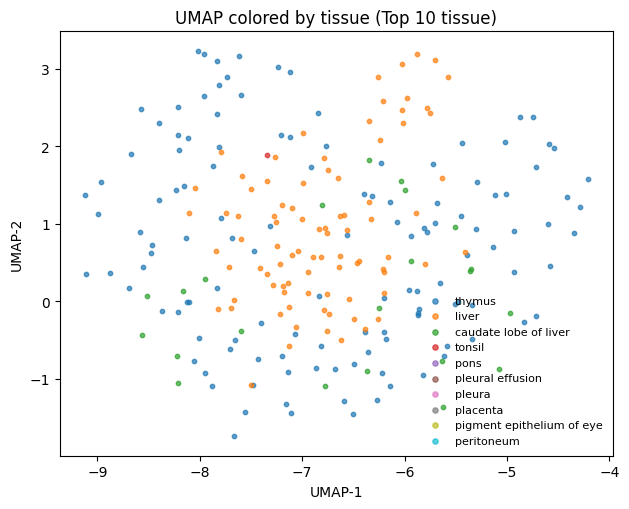

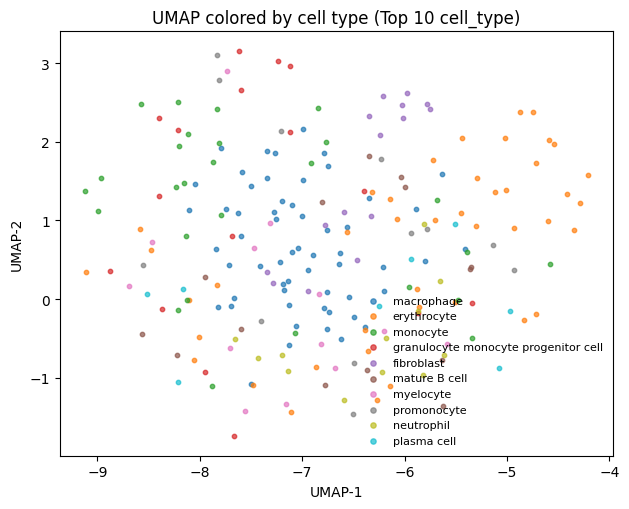

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from umap import UMAP

# Step 1: log1p transform (稀疏矩阵仅作用于非零值)
X_log = X.copy()
X_log.data = np.log1p(X_log.data)

# Step 2: scaling
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_log)

# Step 3: UMAP 降维
um = UMAP(n_neighbors=15, min_dist=0.3, n_components=2, random_state=0)
UM = um.fit_transform(X_scaled)

pc_df = pd.DataFrame({
    "PC1": UM[:, 0],
    "PC2": UM[:, 1],
    "tissue": obs_meta["tissue"].values,
    "cell_type": obs_meta["cell_type"].values,
    "soma_joinid": obs_meta["soma_joinid"].values
})

# --- 画图函数（保留你之前写的） ---
def plot_by_top(column: str, title: str, n_top: int = 5):
    plt.figure(figsize=(6.4, 5.2))
    top = pc_df[column].value_counts().head(n_top).index
    for label in top:
        m = pc_df[column] == label
        plt.scatter(pc_df.loc[m, "PC1"], pc_df.loc[m, "PC2"],
                    s=10, label=str(label), alpha=0.7)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.title(f"{title} (Top {n_top} {column})")
    plt.legend(markerscale=1.2, fontsize=8, frameon=False)
    plt.tight_layout()
    plt.show()

# Example usage
plot_by_top("tissue", "UMAP colored by tissue", n_top=10)
plot_by_top("cell_type", "UMAP colored by cell type", n_top=10)
